In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas import read_csv
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.exposure import equalize_adapthist
from AdvancedLaneLines import *

%matplotlib inline

## Udacity data base set
I will use the 2 databases:
* project database
* udacity database

I extract cars from udacity database, then I flipped each images because car according to driving way are oriented. Also, I generalize the car images.
I extract pedestrians and i cut images without car in order to get a non-cars database.

In [2]:
dframe = read_csv('./object-detection-crowdai/labels.csv')
dframe.head()

,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [3]:
dframe.rename(index=str, columns={"xmax": "ymin", "ymin": "xmax"}, inplace=True)
dframe.head()

,xmin,ymin,xmax,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [4]:
dframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72064 entries, 0 to 72063
Data columns (total 7 columns):
xmin           72064 non-null int64
ymin           72064 non-null int64
xmax           72064 non-null int64
ymax           72064 non-null int64
Frame          72064 non-null object
Label          72064 non-null object
Preview URL    72064 non-null object
dtypes: int64(4), object(3)
memory usage: 4.4+ MB


In [5]:
dframe_car = dframe[dframe['Label'] == 'Car']
dframe_car.head()

,xmin,ymin,xmax,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
5,1726,484,1919,646,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
6,758,557,807,617,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [6]:
if not os.path.exists('./object-detection-crowdai/vehicles'):
    os.makedirs('./object-detection-crowdai/vehicles')
if not os.path.exists('./object-detection-crowdai/flipped_vehicles'):
    os.makedirs('./object-detection-crowdai/flipped_vehicles')    
if not os.path.exists('./object-detection-crowdai/non-vehicles'):
    os.makedirs('./object-detection-crowdai/non-vehicles')
if not os.path.exists('./object-detection-crowdai/pedestrians'):
    os.makedirs('./object-detection-crowdai/pedestrians')

In [7]:
if len(glob.glob('./object-detection-crowdai/vehicles/*.png')) == 0:
    frame = ''
    for i in range(len(dframe_car.index)):
        if frame != dframe_car.iloc[i]['Frame']:
            frame = dframe_car.iloc[i]['Frame']
            img = mpimg.imread('./object-detection-crowdai/{}'.format(frame))
        xmin = dframe_car.iloc[i]['xmin']
        xmax = dframe_car.iloc[i]['xmax']
        ymin = dframe_car.iloc[i]['ymin']
        ymax = dframe_car.iloc[i]['ymax']

        if xmin < xmax and ymin < ymax:
            select = img[ymin:ymax, xmin:xmax,:].copy()
            select = cv2.resize(select, (64, 64))
            mpimg.imsave('./object-detection-crowdai/vehicles/car{}.png'.format(i), select)

In [8]:
dframe_vehicles = dframe[dframe['Label'] != 'Pedestrian']
dframe_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66389 entries, 0 to 72063
Data columns (total 7 columns):
xmin           66389 non-null int64
ymin           66389 non-null int64
xmax           66389 non-null int64
ymax           66389 non-null int64
Frame          66389 non-null object
Label          66389 non-null object
Preview URL    66389 non-null object
dtypes: int64(4), object(3)
memory usage: 4.1+ MB


In [9]:
if len(glob.glob('./object-detection-crowdai/flipped_vehicles/*.png')) == 0:
    vehs = glob.glob('./object-detection-crowdai/vehicles/*.png')
    for i, veh in enumerate(vehs):
        img = mpimg.imread(veh)
        img = cv2.flip(img, 1)
        mpimg.imsave('./object-detection-crowdai/flipped_vehicles/car{}.png'.format(i), img)

In [10]:
if len(glob.glob('./object-detection-crowdai/non-vehicles/*.png')) == 0:

    files = glob.glob('./object-detection-crowdai/*.jpg')
    files_vehicles = np.unique(dframe_vehicles['Frame'].tolist())
    liste =[]
    for i,file in enumerate(files_vehicles):
        liste.append('./object-detection-crowdai/'+file)
    files_vehicles = liste
    files_novehicles = np.setdiff1d(files, files_vehicles)
    print('length of files without vehicles: {}'.format(len(files_novehicles)))
    
    for i,file in enumerate(files_novehicles):
        img = mpimg.imread(file)
        for y in range(0,img.shape[0]//64-1,2):
            for x in range(0,img.shape[1]//64-1,2):
                window = img[y*64:(y+1)*64, x*64:(x+1)*64, :]
                mpimg.imsave('./object-detection-crowdai/non-vehicles/{}1{}{}.png'.format(i, x, y), window)
        imgr = cv2.resize(img, (np.int(img.shape[1]/2), np.int(img.shape[0]/2)))
        for y in range(0,imgr.shape[0]//64-1):
            for x in range(imgr.shape[1]//64-1):
                window = imgr[y*64:(y+1)*64, x*64:(x+1)*64, :]
                mpimg.imsave('./object-detection-crowdai/non-vehicles/{}2{}{}.png'.format(i, x, y), window)
        imgr = cv2.resize(img, (np.int(img.shape[1]/3), np.int(img.shape[0]/3)))
        for y in range(0,imgr.shape[0]//64-1):
            for x in range(imgr.shape[1]//64-1):
                window = imgr[y*64:(y+1)*64, x*64:(x+1)*64, :]
                mpimg.imsave('./object-detection-crowdai/non-vehicles/{}3{}{}.png'.format(i, x, y), window)
        imgr = cv2.resize(img, (np.int(img.shape[1]/4), np.int(img.shape[0]/4)))
        for y in range(0,imgr.shape[0]//64-1):
            for x in range(imgr.shape[1]//64-1):
                window = imgr[y*64:(y+1)*64, x*64:(x+1)*64, :]
                mpimg.imsave('./object-detection-crowdai/non-vehicles/{}4{}{}.png'.format(i, x, y), window)


In [11]:
dframe_pedestrians = dframe[dframe['Label'] == 'Pedestrian']
dframe_pedestrians.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5675 entries, 117 to 71996
Data columns (total 7 columns):
xmin           5675 non-null int64
ymin           5675 non-null int64
xmax           5675 non-null int64
ymax           5675 non-null int64
Frame          5675 non-null object
Label          5675 non-null object
Preview URL    5675 non-null object
dtypes: int64(4), object(3)
memory usage: 354.7+ KB


In [12]:
if len(glob.glob('./object-detection-crowdai/pedestrians/*.png')) == 0:
    frame = ''
    for i in range(len(dframe_pedestrians.index)):
        if frame != dframe_pedestrians.iloc[i]['Frame']:
            frame = dframe_pedestrians.iloc[i]['Frame']
            img = mpimg.imread('./object-detection-crowdai/{}'.format(frame))
        xmin = dframe_pedestrians.iloc[i]['xmin']
        xmax = dframe_pedestrians.iloc[i]['xmax']
        ymin = dframe_pedestrians.iloc[i]['ymin']
        ymax = dframe_pedestrians.iloc[i]['ymax']

        if xmin < xmax and ymin < ymax:
            select = img[ymin:ymax, xmin:xmax,:].copy()
            select = cv2.resize(select, (64, 64))
            mpimg.imsave('./object-detection-crowdai/pedestrians/ped{}.png'.format(i), select)

## Data collection
For test set, I will use last samples of udacity database.

For train set, I will use samples of project database and udacity database, in the same proportion.

In [13]:
cars = glob.glob('./vehicles/*/*.png')
print('lenght of cars: {}'.format(len(cars)))
notcars = glob.glob('./non-vehicles/*/*.png')
print('lenght of notcars: {}'.format(len(notcars)))
cars_udacitydata = glob.glob('./object-detection-crowdai/vehicles/*.png')
print('lenght of cars_udacitydata: {}'.format(len(cars_udacitydata)))
flipped_cars_udacitydata = glob.glob('./object-detection-crowdai/flipped_vehicles/*.png')
print('lenght of flipped_cars_udacitydata: {}'.format(len(flipped_cars_udacitydata)))
notcars_udacitydata = glob.glob('./object-detection-crowdai/non-vehicles/*.png')
print('lenght of notcars_udacitydata: {}'.format(len(notcars_udacitydata)))
pedestrians_udacitydata = glob.glob('./object-detection-crowdai/pedestrians/*.png')
print('lenght of pedestrians_udacitydata: {}'.format(len(pedestrians_udacitydata)))

lenght of cars: 8792
lenght of notcars: 8968
lenght of cars_udacitydata: 62567
lenght of flipped_cars_udacitydata: 62567
lenght of notcars_udacitydata: 62894
lenght of pedestrians_udacitydata: 5674


In [14]:
cars_test = cars_udacitydata[-5000:] + flipped_cars_udacitydata[:5000]
notcars_test = notcars_udacitydata[-7500:] + pedestrians_udacitydata[2500:]

cars_uda = cars_udacitydata[:-5000]
np.random.shuffle(cars_uda)
flipped_cars_uda = flipped_cars_udacitydata[5000:]
np.random.shuffle(flipped_cars_uda)
notcars_uda = notcars_udacitydata[:-7500]
np.random.shuffle(notcars_uda)

cars_train = cars + cars_uda[:4000] + flipped_cars_uda[:4000]
notcars_train = notcars + pedestrians_udacitydata[:2500] + notcars_uda[:5500]

np.random.shuffle(cars_train)
np.random.shuffle(notcars_train)
np.random.shuffle(cars_test)
np.random.shuffle(notcars_test)


print('lenght of cars_train: {}'.format(len(cars_train)))
print('lenght of notcars_train: {}'.format(len(notcars_train)))
print('lenght of cars_test: {}'.format(len(cars_test)))
print('lenght of notcars_test: {}'.format(len(notcars_test)))

lenght of cars_train: 16792
lenght of notcars_train: 16968
lenght of cars_test: 10000
lenght of notcars_test: 10674


## Data exploration

Train set: Your function returned a count of 16792  cars and 16968  non-cars
of size:  (64, 64, 3)  and data type: float32
Test set: Your function returned a count of 10000  cars and 10674  non-cars
of size:  (64, 64, 3)  and data type: float32


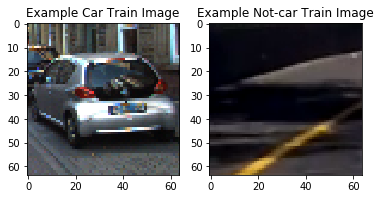

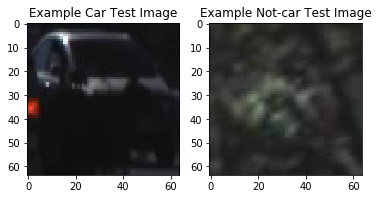

In [15]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[0])[:,:,:3]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars_train, notcars_train)

print('Train set: Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars_train))
notcar_ind = np.random.randint(0, len(notcars_train))
    
# Read in car / not-car images
car_image = mpimg.imread(cars_train[car_ind])[:,:,:3]
notcar_image = mpimg.imread(notcars_train[notcar_ind])[:,:,:3]


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Train Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Train Image')

data_info = data_look(cars_test, notcars_test)

print('Test set: Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars_test))
notcar_ind = np.random.randint(0, len(notcars_test))
    
# Read in car / not-car images
car_image = mpimg.imread(cars_test[car_ind])[:,:,:3]
notcar_image = mpimg.imread(notcars_test[notcar_ind])[:,:,:3]


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Test Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Test Image')

## Search and Classify
I treak paramater, I choose to use 3 kind of features: HOG, history of colors, and spatial binning dimension.

According to accuracy of models, this choice was not evident. But finally, for vehicle detection result, it is the best choice.

In [16]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
car_features_train = extract_features(cars_train, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features_train = extract_features(notcars_train, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
car_features_test = extract_features(cars_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features_test = extract_features(notcars_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X_tr = np.vstack((car_features_train, notcar_features_train)).astype(np.float64)
X_te = np.vstack((car_features_test, notcar_features_test)).astype(np.float64)
X_te_car = np.vstack((car_features_test)).astype(np.float64)
X_te_notcar = np.vstack((notcar_features_test)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_tr)
# Apply the scaler to X
scaled_X_train = X_scaler.transform(X_tr)
scaled_X_test = X_scaler.transform(X_te)
scaled_X_test_car = X_scaler.transform(X_te_car)
scaled_X_test_notcar = X_scaler.transform(X_te_notcar)

# Define the labels vector
y_tr = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_te = np.hstack((np.ones(len(car_features_test)), np.zeros(len(notcar_features_test))))
y_te_car = np.hstack(np.ones(len(car_features_test)))
y_te_notcar = np.hstack(np.zeros(len(notcar_features_test)))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, _, y_train, _ = train_test_split(
    scaled_X_train, y_tr, test_size=0., random_state=rand_state)
X_test, _, y_test, _ = train_test_split(
    scaled_X_test, y_te, test_size=0., random_state=rand_state)
X_test_car, _, y_test_car, _ = train_test_split(
    scaled_X_test_car, y_te_car, test_size=0., random_state=rand_state)
X_test_notcar, _, y_test_notcar, _ = train_test_split(
    scaled_X_test_notcar, y_te_notcar, test_size=0., random_state=rand_state)



print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('Test Accuracy of SVC for cars = ', round(svc.score(X_test_car, y_test_car), 4))
print('Test Accuracy of SVC for not cars = ', round(svc.score(X_test_notcar, y_test_notcar), 4))
# Check the prediction time for a test sample
t=time.time()
pred = svc.predict(X_test)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict SVC...')

132.77 Seconds to extract features...
Using: 7 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1116
57.49 Seconds to train SVC...
Test Accuracy of SVC =  0.8878
Test Accuracy of SVC for cars =  0.9071
Test Accuracy of SVC for not cars =  0.8698
0.02 Seconds to predict SVC...


### Try to reduce number of features

By using forest ensemble, I try to reduce the number of features by keeping only the most relevant feature. I loose a little bit accuracy but I win time for prediction.

In [17]:
tree = ExtraTreesClassifier()
t=time.time()
tree.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train tree...')
# Check the score of the tree
print('Test Accuracy of tree = ', round(tree.score(X_test, y_test), 4))
print('Test Accuracy of tree for cars = ', round(tree.score(X_test_car, y_test_car), 4))
print('Test Accuracy of tree for not cars = ', round(tree.score(X_test_notcar, y_test_notcar), 4))
# Check the prediction time for a test sample
t=time.time()
tree.predict(X_test)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict tree...')

2.39 Seconds to train tree...
Test Accuracy of tree =  0.875
Test Accuracy of tree for cars =  0.8874
Test Accuracy of tree for not cars =  0.8634
0.13 Seconds to predict tree...


In [18]:
reduce_features = SelectFromModel(tree, prefit=True)
X_reduce_train = reduce_features.transform(X_train)
X_reduce_test = reduce_features.transform(X_test)
X_reduce_test_car = reduce_features.transform(X_test_car)
X_reduce_test_notcar = reduce_features.transform(X_test_notcar)

print(X_train.shape)
print(X_test.shape)
print(X_reduce_train.shape)
print(X_reduce_test.shape)

print('Feature vector length:', len(X_reduce_train[0]))

(33760, 1116)
(20674, 1116)
(33760, 230)
(20674, 230)
Feature vector length: 230


In [19]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_reduce_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_reduce_test, y_test), 4))
print('Test Accuracy of SVC for cars = ', round(svc.score(X_reduce_test_car, y_test_car), 4))
print('Test Accuracy of SVC for not cars = ', round(svc.score(X_reduce_test_notcar, y_test_notcar), 4))
# Check the prediction time for a test sample
t=time.time()
pred = svc.predict(X_reduce_test)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict SVC...')

20.53 Seconds to train SVC...
Test Accuracy of SVC =  0.8752
Test Accuracy of SVC for cars =  0.8742
Test Accuracy of SVC for not cars =  0.8761
0.0 Seconds to predict SVC...


## Search model
I try different kind of model:
* Linear SVC
* Rbf SVC
* Forests of tree
* AdaBoost

I set it with gridsearchCV method.

In [ ]:
parameters = {'C':[0.5, 1, 1.5]}
svcl = LinearSVC()
clf = GridSearchCV(svcl, parameters)
clf.fit(X_train, y_train) 
clf.best_params_

In [20]:
# Use a linear SVC 
svcl = LinearSVC(C = 0.7)
# Check the training time for the SVC
t=time.time()
svcl.fit(X_reduce_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train Linear SVC...')
# Check the score of the SVC
print('Test Accuracy of Linear SVC = ', round(svcl.score(X_reduce_test, y_test), 4))
print('Test Accuracy of Linear SVC for cars = ', round(svcl.score(X_reduce_test_car, y_test_car), 4))
print('Test Accuracy of Linear SVC for not cars = ', round(svcl.score(X_reduce_test_notcar, y_test_notcar), 4))
# Check the prediction time for a test sample
t=time.time()
pred = svcl.predict(X_reduce_test)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict Linear SVC...')

19.23 Seconds to train Linear SVC...
Test Accuracy of Linear SVC =  0.8798
Test Accuracy of Linear SVC for cars =  0.8751
Test Accuracy of Linear SVC for not cars =  0.8842
0.0 Seconds to predict Linear SVC...


In [ ]:
parameters = {'C':[2, 3, 4]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train[:10000], y_train[:10000]) 
clf.best_params_

In [21]:
# Use a SVC 
svc = SVC(kernel='rbf', C=3, gamma='auto')
t=time.time()
svc.fit(X_reduce_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the tree
print('Test Accuracy of SVC = ', round(svc.score(X_reduce_test, y_test), 4))
print('Test Accuracy of SVC for car = ', round(svc.score(X_reduce_test_car, y_test_car), 4))
print('Test Accuracy of SVC for not cars = ', round(svc.score(X_reduce_test_notcar, y_test_notcar), 4))
# Check the prediction time for a test sample
t=time.time()
svc.predict(X_reduce_test)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict SVC...')

209.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9459
Test Accuracy of SVC for car =  0.9451
Test Accuracy of SVC for not cars =  0.9466
40.21 Seconds to predict SVC...


In [ ]:
parameters = {'n_estimators':[100, 200, 300], 'max_depth':[50, 60, 70]}
tree = ExtraTreesClassifier()
clf = GridSearchCV(tree, parameters)
clf.fit(X_train, y_train) 
clf.best_params_

In [22]:
tree = ExtraTreesClassifier(n_estimators = 200, max_depth = 100)
t=time.time()
tree.fit(X_reduce_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train forest...')
# Check the score of the tree
print('Test Accuracy of forest = ', round(tree.score(X_reduce_test, y_test), 4))
print('Test Accuracy of forest for cars = ', round(tree.score(X_reduce_test_car, y_test_car), 4))
print('Test Accuracy of forest for not cars = ', round(tree.score(X_reduce_test_notcar, y_test_notcar), 4))
# Check the prediction time for a test sample
t=time.time()
tree.predict(X_reduce_test)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict forest...')

15.97 Seconds to train forest...
Test Accuracy of forest =  0.9115
Test Accuracy of forest for cars =  0.9571
Test Accuracy of forest for not cars =  0.8688
0.98 Seconds to predict forest...


In [23]:
ada = AdaBoostClassifier(n_estimators = 200)
t=time.time()
ada.fit(X_reduce_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train forest...')
# Check the score of the tree
print('Test Accuracy of Adaboost = ', round(ada.score(X_reduce_test, y_test), 4))
print('Test Accuracy of Adaboost for cars = ', round(ada.score(X_reduce_test_car, y_test_car), 4))
print('Test Accuracy of Adaboost for not cars = ', round(ada.score(X_reduce_test_notcar, y_test_notcar), 4))
# Check the prediction time for a test sample
t=time.time()
ada.predict(X_reduce_test)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict Adaboost...')

148.23 Seconds to train forest...
Test Accuracy of Adaboost =  0.905
Test Accuracy of Adaboost for cars =  0.9164
Test Accuracy of Adaboost for not cars =  0.8942
0.87 Seconds to predict Adaboost...


## Sliding window implementation
I slide widow with scale: 1, 1.5, 2, 3 and 5

In [24]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, X_scaler, reducer, orient = 7, pix_per_cell = 16,
              cell_per_block = 2, spatial_size = (16, 16), hist_bins = 32, cells_per_step = 2):
    
    img = img.astype(np.float32)/255
    bboxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    chv = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (chv.shape[1] // pix_per_cell) 
    nyblocks = (chv.shape[0] // pix_per_cell) 
    # nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)

    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
    # Compute individual channel HOG features for the entire image
    hog = get_hog_features(chv, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog[ypos:ypos+nblocks_per_window-1, xpos:xpos+nblocks_per_window-1].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            # Reduce dimension of features
            test_features = reducer.transform(test_features)
            
            test_prediction = clf.predict(test_features)
            
            #test_prediction = 1
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart))) 
    
    return bboxes

In [25]:
def search_bboxes(image, clf, X_scaler, reduce_features):
    bboxes = []
    bboxes = bboxes + find_cars(image, 416, 480, 1., clf, X_scaler, reduce_features, cells_per_step = 1)
    bboxes = bboxes + find_cars(image, 400, 600, 2., clf, X_scaler, reduce_features, cells_per_step = 2)
    bboxes = bboxes + find_cars(image, 480, 720, 3., clf, X_scaler, reduce_features, cells_per_step = 2)
    
    return bboxes 

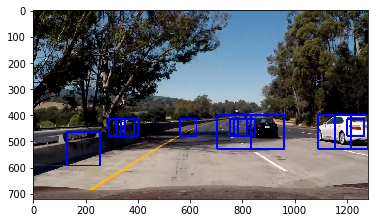

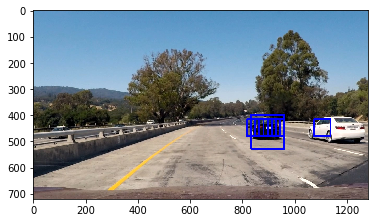

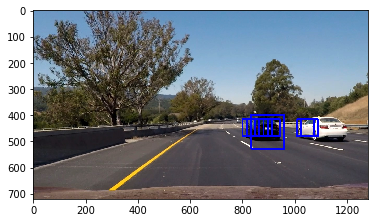

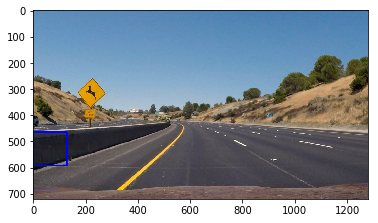

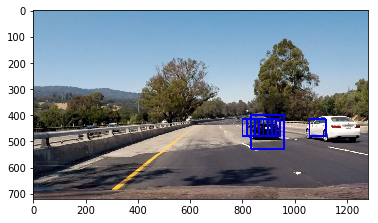

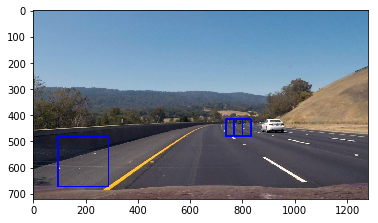

In [26]:
test_images = glob.glob('./test_images/*.jpg')
    
for img in test_images:
    image = mpimg.imread(img)
    bboxes = search_bboxes(image, svc, X_scaler, reduce_features)
    out_img = draw_boxes(image, bboxes)
    fig = plt.figure()
    plt.imshow(out_img)

## Heatmap persistency
I use a class to receive previous heatmap (story of heatmap) in order to cancel wrong classification which appears episodically.

In [27]:
# Define a class to receive heatmap story
class Heatmap():
    def __init__(self, image):
        # was the heatmap image in the last iteration
        self.heats = np.zeros_like(image[:,:,0]).astype(np.int16)
        
    def update_heat(self, bbox_list):
        # Iterate through list of bboxes
        add_heat = np.zeros_like(self.heats).astype(np.int16)
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            add_heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        add_heat[add_heat == 0] = -1
        self.heats += add_heat
        self.heats = np.clip(self.heats, 0, 50)

## Prediction drawing
I add +1 to each predicted heat and -1 to the other pixels.

Then I apply one threshold of 10 to help remove false positives.

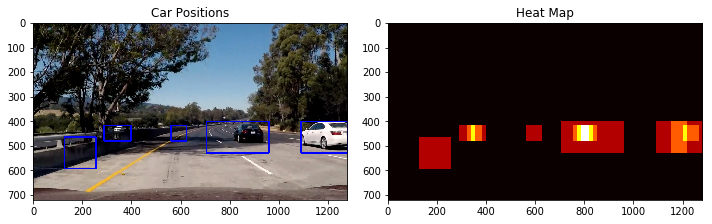

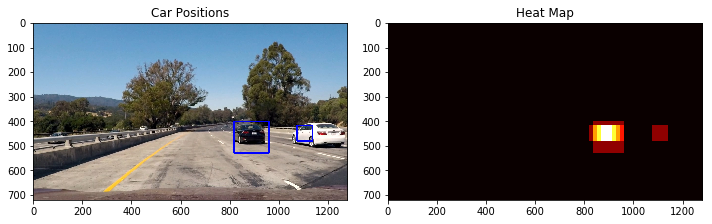

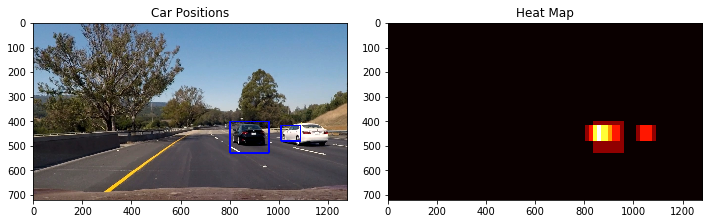

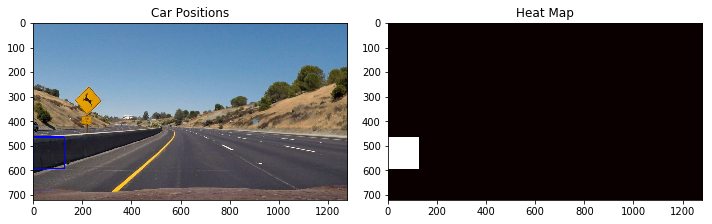

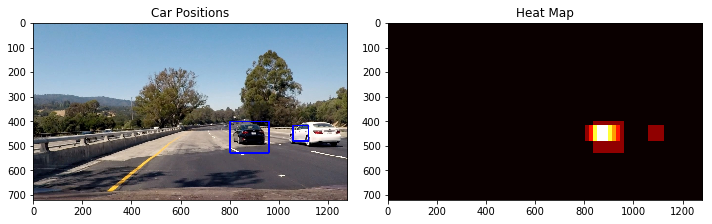

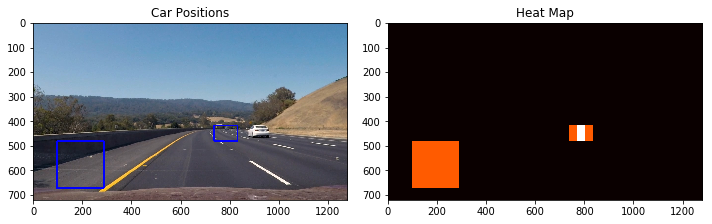

In [28]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

for img in test_images:
    # Read in image similar to one shown above 
    image = mpimg.imread(img)
    heatmap = Heatmap(image)

    # Update heat to each box in box list
    bboxes = search_bboxes(image, svc, X_scaler, reduce_features)
    heatmap.update_heat(bboxes)

    # Apply threshold to help remove false positives
    heat = heatmap.heats
    heat_thresh = apply_threshold(heat,0)

    # Find final boxes from heatmap using label function
    labels = label(heat_thresh)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heat_thresh, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

0.89 Seconds to perform image...
0.82 Seconds to perform image...
0.82 Seconds to perform image...
0.82 Seconds to perform image...
0.82 Seconds to perform image...
0.82 Seconds to perform image...


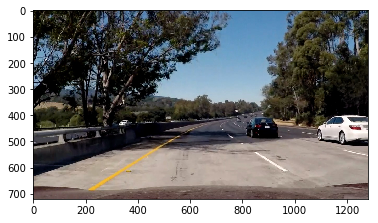

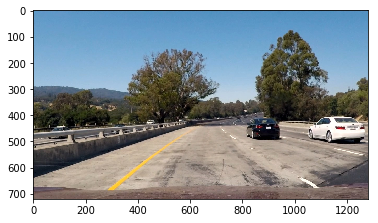

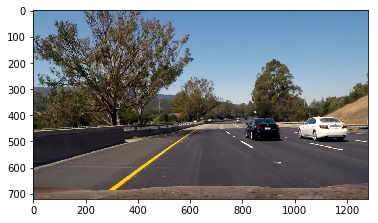

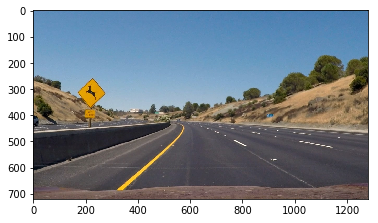

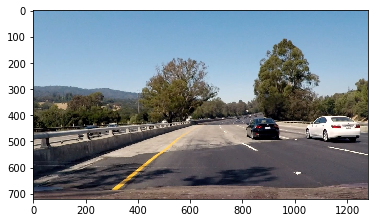

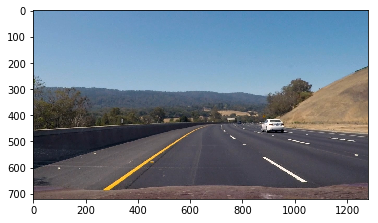

In [29]:
def pipeline_vehicles_detection(image, heatmap, clf, scaler, reducer):
    
    # Update heat to each box in box list
    bboxes = search_bboxes(image, clf, X_scaler, reduce_features)
    heatmap.update_heat(bboxes)

    # Apply threshold to help remove false positives
    heat = heatmap.heats.copy()
    #print(np.unique(heat[:,1000//16:]))
    heat_thresh = apply_threshold(heat, 45)
    #print(np.unique(heat_thresh[:,1000//16:]))

    # Find final boxes from heatmap using label function
    labels = label(heat_thresh)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    #draw_img = draw_boxes(image, bboxes)
    return draw_img

for img in test_images:
    image = mpimg.imread(img)
    t = time.time()
    heatmap = Heatmap(image)
    out_img = pipeline_vehicles_detection(image, heatmap, svc, X_scaler, reduce_features)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to perform image...')
    fig = plt.figure()
    plt.imshow(out_img)

## Test Video

In [30]:
# tranform any clip with parameters:
def vehiclesdetect_video(clip, clf, scaler, reducer):
    heatmap = Heatmap(image)
    print('heatmap created')
    def image_video (image):
        return pipeline_vehicles_detection(image, heatmap, clf, scaler, reducer)
    return clip.fl_image(image_video)

In [31]:
test_output = './output_images/output_test_video.mp4'
clip = VideoFileClip('test_video.mp4')
vehicules_clip = clip.fx(vehiclesdetect_video, svc, X_scaler, reduce_features)
%time vehicules_clip.write_videofile(test_output, audio=False)

heatmap created
[MoviePy] >>>> Building video ./output_images/output_test_video.mp4
[MoviePy] Writing video ./output_images/output_test_video.mp4


 97%|█████████▋| 38/39 [00:33<00:00,  1.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_test_video.mp4 

CPU times: user 37.7 s, sys: 128 ms, total: 37.9 s
Wall time: 34.3 s


In [32]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(test_output))

## Project Video

In [33]:
project_output = './output_images/output_project_video.mp4'
clip = VideoFileClip('project_video.mp4')
vehicules_clip = clip.fx(vehiclesdetect_video, svc, X_scaler, reduce_features)
%time vehicules_clip.write_videofile(project_output, audio=False)

heatmap created
[MoviePy] >>>> Building video ./output_images/output_project_video.mp4
[MoviePy] Writing video ./output_images/output_project_video.mp4


100%|█████████▉| 1260/1261 [36:58<00:01,  1.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_project_video.mp4 

CPU times: user 34min 30s, sys: 7.22 s, total: 34min 37s
Wall time: 37min 4s


In [34]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Other video

In [35]:
challenge_output = './output_images/output_challenge_video.mp4'
clip = VideoFileClip('challenge_video.mp4')
vehicules_clip = clip.fx(vehiclesdetect_video, svc, X_scaler, reduce_features)
%time vehicules_clip.write_videofile(challenge_output, audio=False)

heatmap created
[MoviePy] >>>> Building video ./output_images/output_challenge_video.mp4
[MoviePy] Writing video ./output_images/output_challenge_video.mp4


100%|██████████| 485/485 [15:16<00:00,  1.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_challenge_video.mp4 

CPU times: user 14min 2s, sys: 2.87 s, total: 14min 5s
Wall time: 15min 23s


In [36]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [37]:
hchallenge_output = './output_images/output_hchallenge_video.mp4'
clip = VideoFileClip('harder_challenge_video.mp4')
vehicules_clip = clip.fx(vehiclesdetect_video, svc, X_scaler, reduce_features)
%time vehicules_clip.write_videofile(hchallenge_output, audio=False)

heatmap created
[MoviePy] >>>> Building video ./output_images/output_hchallenge_video.mp4
[MoviePy] Writing video ./output_images/output_hchallenge_video.mp4


100%|█████████▉| 1199/1200 [37:37<00:01,  1.77s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_hchallenge_video.mp4 

CPU times: user 34min 31s, sys: 6.98 s, total: 34min 38s
Wall time: 37min 44s


In [38]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(hchallenge_output))

## Vehilcle + Lane Lines Detection

In [39]:
def pipeline_vehicles_LaneLines_detection(image, heatmap, clf, scaler, reducer, left, right):
    
    lines_image = drawing_lane_pipeline(image, left, right) 
    
    # Update heat to each box in box list
    bboxes = search_bboxes(image, clf, X_scaler, reduce_features)
    heatmap.update_heat(bboxes)

    # Apply threshold to help remove false positives
    heat = heatmap.heats.copy()
    heat_thresh = apply_threshold(heat, 8)

    # Find final boxes from heatmap using label function
    labels = label(heat_thresh)
    draw_img = draw_labeled_bboxes(lines_image, labels)
    
    return draw_img

In [40]:
# tranform any clip with parameters:
def bothdetect_video(clip, clf, scaler, reducer):
    heatmap = Heatmap(image)
    left_line = Line()
    right_line = Line()
    print('heatmap and lines created')
    def image_video (image):
        return pipeline_vehicles_LaneLines_detection(image, heatmap, clf, scaler, reducer, left_line, right_line)
    return clip.fl_image(image_video)

In [41]:
project2_output = './output_images/output_project2_video.mp4'
clip = VideoFileClip('project_video.mp4')
vehicules_clip = clip.fx(bothdetect_video, svc, X_scaler, reduce_features)
%time vehicules_clip.write_videofile(project2_output, audio=False)

heatmap and lines created
[MoviePy] >>>> Building video ./output_images/output_project2_video.mp4
[MoviePy] Writing video ./output_images/output_project2_video.mp4


100%|█████████▉| 1260/1261 [52:27<00:02,  2.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_project2_video.mp4 

CPU times: user 52min 46s, sys: 2min 14s, total: 55min
Wall time: 52min 33s


In [42]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(project2_output))